<a href="https://colab.research.google.com/github/hhaemin/computer_vision/blob/main/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

## RANSAC

dataset에서 노이즈를 제거하고 모델을 예측하는 알고리즘
특정 임계값 이상의 data를 완전히 무시해버리는 특성이 있어 outlier에 강건한 알고리즘

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

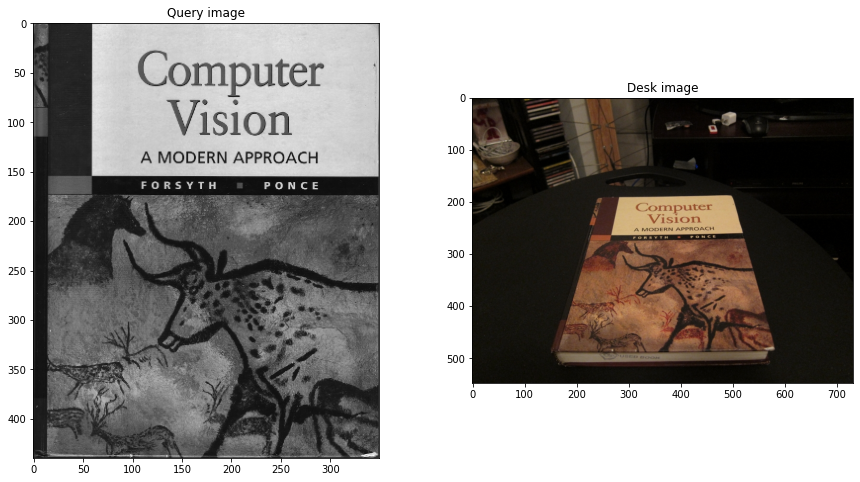

In [2]:
queryImage= 'cv_cover.jpg'
trainImage='cv_desk.png'


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(cv.imread(queryImage), cv.COLOR_BGR2RGB))
plt.title('Query image')
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(cv.imread(trainImage), cv.COLOR_BGR2RGB))
plt.title('Desk image')
plt.show()

img1 = cv.imread(queryImage,cv.IMREAD_GRAYSCALE)         
img2 = cv.imread(trainImage,cv.IMREAD_GRAYSCALE) 

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)



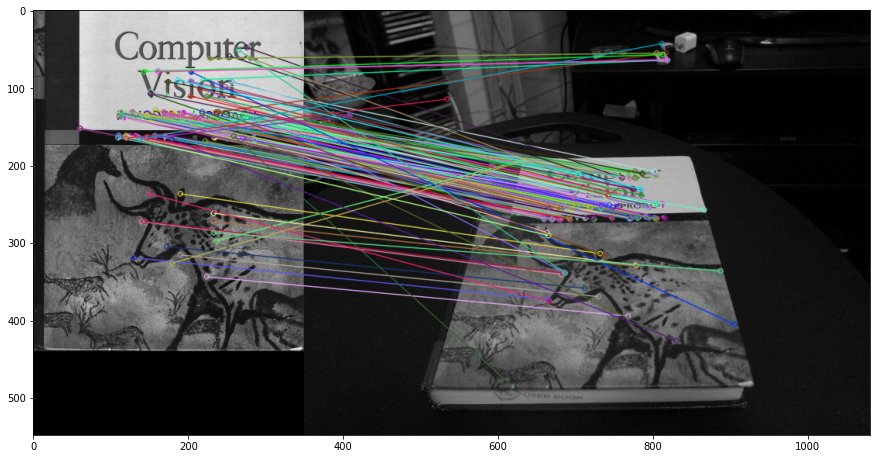

In [3]:
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

## Find homography and warping

In [4]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

h, mask = cv.findHomography(points1, points2, cv.RANSAC)

height, width = img2.shape

im1_warped = cv.warpPerspective(img1, h, (width, height))

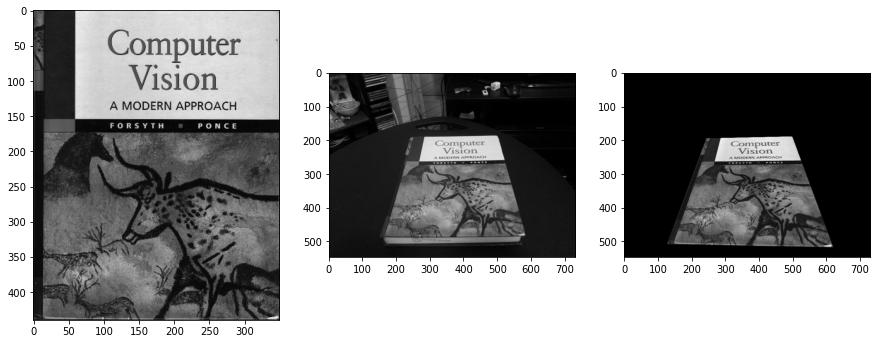

In [5]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im1_warped, cmap='gray')
plt.show()

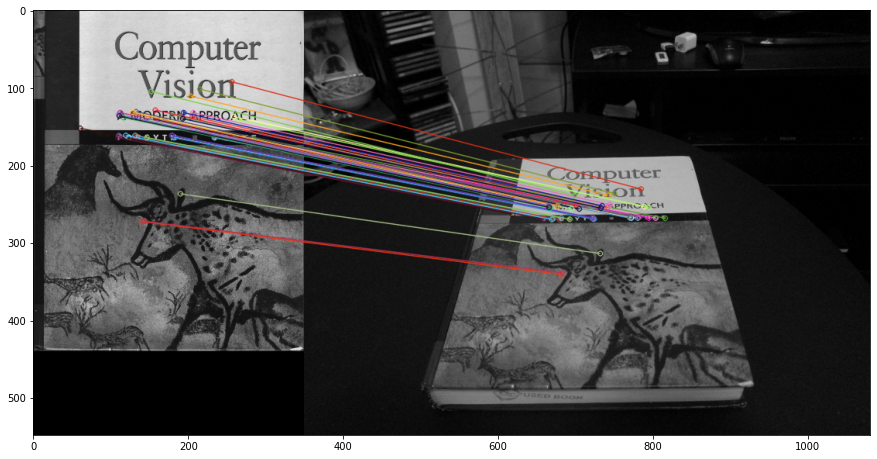

In [6]:
matches_opencv_ransac = np.array(matches)[np.nonzero(mask.squeeze())]
img3 = cv.drawMatches(img1,kp1,img2,kp2, matches_opencv_ransac ,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

## Using Kornia


https://kornia.readthedocs.io/en/latest/geometry.ransac.html?highlight=ransac

In [7]:
! pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 42.4 MB/s 


tensor([[ 7.4488e-01, -3.2374e-01,  2.3612e+02],
        [-2.5232e-02,  2.5766e-01,  1.9154e+02],
        [-5.4172e-05, -8.3858e-04,  1.0000e+00]])
torch.Size([144]) (144, 2) (144, 2)


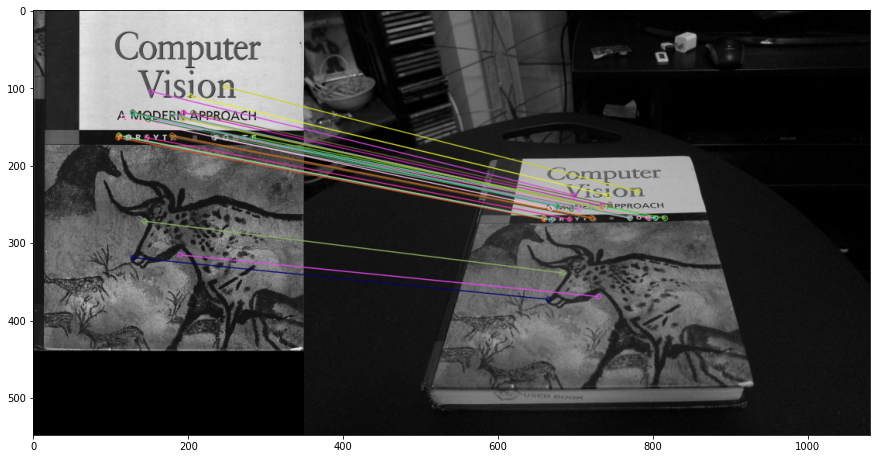

In [8]:
import torch
import kornia.geometry as KG
ransac = KG.ransac.RANSAC(model_type='homography')

# print(points1, points2, points1.shape)
H, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(H)

print(inliers.shape, points1.shape, points2.shape)

matches_kornia = np.array(matches)[np.nonzero(inliers.squeeze())][:, 0]


img3 = cv.drawMatches(img1,kp1,img2,kp2,matches_kornia,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

In [9]:
ransac = KG.ransac.RANSAC(model_type='fundamental')
F, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(F)  ## fundamental matrix

tensor([[-3.5466e-05,  1.1356e-03, -1.5284e-01],
        [-1.9157e-03,  2.0842e-04,  1.8276e-01],
        [ 5.0190e-01, -4.0874e-01,  1.0000e+00]])


In [10]:
# ransac = KG.ransac.RANSAC(model_type='fundamental')